In [1]:
!pip install pandas
!pip install pyarrow

!pip install Pillow
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install tqdm
!pip install ipdb
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 95.5 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 65.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 81.8 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6

In [1]:
from pathlib import Path
import os


# os.chdir("/root/workspace/mlx-week5/sid")
print(os.getcwd())
# root_path = Path(os.getcwd()).resolve().parents[0]
# print(root_path)
# os.chdir("/root/workspace/mlx44/src")
# os.mkdir(root_path / "workspace/mlx-week5")
# root = Path("/Users/sid/workspace/mlx-week5")
root = Path("/root/workspace/mlx-week5")
root.mkdir(exist_ok=True)
train_data_path = root / "train"
print(train_data_path)
os.chdir(root)

/
/root/workspace/mlx-week5/train


In [2]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import io
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict
import numpy as np
import itertools as its
from tqdm import tqdm
import ipdb
from collections import namedtuple
from importlib import reload

In [3]:
# How to check is mps is available on my M1 MAC?
torch.backends.mps.is_available()
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    #     else ("mps" if torch.backends.mps.is_available() else "cpu")
)
device

device(type='cuda')

# Load the data from a single parquet file

In [4]:
# read a parquet file into a pandas dataframe
import pandas as pd
import pyarrow.parquet as pq

first_file = pd.read_parquet(train_data_path / "0000.parquet", engine="pyarrow")

In [5]:
all_sentences = first_file["text"].values
all_sentences = all_sentences.tolist()
all_sentences[0:5]

['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.',
 'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves that we

In [6]:
len(all_sentences), all_sentences[100]

(529930,
 "There was a little girl with dark hair. Her name was Joy. She lived in a big house with her parents. One day, Joy was playing outside in her garden. Suddenly, she felt something on her leg - something pinching her. It was a big, black bug! \n\nJoy screamed and tried to get away, but the bug kept following her. She tried to run and hide, but it was too quick. \n\nJoy's parents heard her cries and came running. They used a stick to help her get rid of the bug. After the bug was gone, they hugged Joy and told her everything would be alright. \n\nWhen the bug was gone, Joy felt relieved and happy. She went back to playing in the garden, making sure she didn't step on any more bugs.")

# Use sentence piece to tokenize the sentences

In [15]:
# Lets tokenize using sentence piece
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
import io

VOCAB_SIZE = 10000
SOS = "<SOS>"
EOS = "<EOS>"


# for article in articles[0:100]:
def get_data():
    for i in range(100):
        file = pd.read_parquet(
            train_data_path / f"{str(i).zfill(4)}.parquet", engine="pyarrow"
        )
        for sentence in file["text"].values:
            yield sentence


def get_model(train=False):
    model = io.BytesIO()
    model_filename = root / "models/tiny_stories_tokenizer.model"
    if train:
        SentencePieceTrainer.train(
            sentence_iterator=(story.lower() for story in all_sentences),
            model_writer=model,
            vocab_size=VOCAB_SIZE,
            user_defined_symbols=[SOS, EOS],
            # max_sentence_length=4196,
            # model_type="BPE",
        )
        sp_processor = SentencePieceProcessor(model_proto=model.getvalue())
    else:
        sp_processor = SentencePieceProcessor(model_file=str(model_filename))
    return sp_processor, model


def save_model(model):
    model_filename = root / "models/tiny_stories_tokenizer_2.model"
    with open(model_filename, "wb") as f:
        print('.')
        f.write(model.getvalue())

In [12]:
root

PosixPath('/root/workspace/mlx-week5')

In [8]:
sp_processor, model = get_model(train=False)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <SOS>
  user_defined_symbols: <EOS>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_

In [16]:
# EXECUTE ONCE WHEN YOU HAVE IT MADE
save_model(model)

.


In [18]:
print(all_sentences[100])
print(".")
print(
    " ".join(
        [
            w
            for lst in sp_processor.encode_as_pieces([story.lower() for story in all_sentences[100:101]])
            for w in lst
        ]
    )
)
print("..")
print(sp_processor.encode_as_ids(all_sentences[100:101]))

There was a little girl with dark hair. Her name was Joy. She lived in a big house with her parents. One day, Joy was playing outside in her garden. Suddenly, she felt something on her leg - something pinching her. It was a big, black bug! 

Joy screamed and tried to get away, but the bug kept following her. She tried to run and hide, but it was too quick. 

Joy's parents heard her cries and came running. They used a stick to help her get rid of the bug. After the bug was gone, they hugged Joy and told her everything would be alright. 

When the bug was gone, Joy felt relieved and happy. She went back to playing in the garden, making sure she didn't step on any more bugs.
.
▁there ▁was ▁a ▁little ▁girl ▁with ▁dark ▁hair . ▁her ▁name ▁was ▁joy . ▁she ▁lived ▁in ▁a ▁big ▁house ▁with ▁her ▁parents . ▁one ▁day , ▁joy ▁was ▁playing ▁outside ▁in ▁her ▁garden . ▁suddenly , ▁she ▁felt ▁something ▁on ▁her ▁leg ▁- ▁something ▁pinching ▁her . ▁it ▁was ▁a ▁big , ▁black ▁bug ! ▁joy ▁screamed ▁and ▁

In [20]:
sp_processor.encode_as_pieces(
    "<SOS> hen the bug was gone, Joy felt relieved and happy. She went <EOS>"
)

# sp_processor.encode_as_ids("<SOS>en the bug was gone, Joy felt relieved and happy. She went <EOS>")
for sentence in all_sentences[100:110]:
    sentence = f"<SOS>{sentence.lower()}<EOS>"
    print(sp_processor.encode_as_pieces(sentence))
# sp_processor.encode_as_pieces("<SOS>hen the bug was gone, Joy felt relieved and happy. She went<EOS>")

['▁', '<SOS>', 'there', '▁was', '▁a', '▁little', '▁girl', '▁with', '▁dark', '▁hair', '.', '▁her', '▁name', '▁was', '▁joy', '.', '▁she', '▁lived', '▁in', '▁a', '▁big', '▁house', '▁with', '▁her', '▁parents', '.', '▁one', '▁day', ',', '▁joy', '▁was', '▁playing', '▁outside', '▁in', '▁her', '▁garden', '.', '▁suddenly', ',', '▁she', '▁felt', '▁something', '▁on', '▁her', '▁leg', '▁-', '▁something', '▁pinching', '▁her', '.', '▁it', '▁was', '▁a', '▁big', ',', '▁black', '▁bug', '!', '▁joy', '▁screamed', '▁and', '▁tried', '▁to', '▁get', '▁away', ',', '▁but', '▁the', '▁bug', '▁kept', '▁following', '▁her', '.', '▁she', '▁tried', '▁to', '▁run', '▁and', '▁hide', ',', '▁but', '▁it', '▁was', '▁too', '▁quick', '.', '▁joy', "'", 's', '▁parents', '▁heard', '▁her', '▁cries', '▁and', '▁came', '▁running', '.', '▁they', '▁used', '▁a', '▁stick', '▁to', '▁help', '▁her', '▁get', '▁rid', '▁of', '▁the', '▁bug', '.', '▁after', '▁the', '▁bug', '▁was', '▁gone', ',', '▁they', '▁hugged', '▁joy', '▁and', '▁told', '▁her'

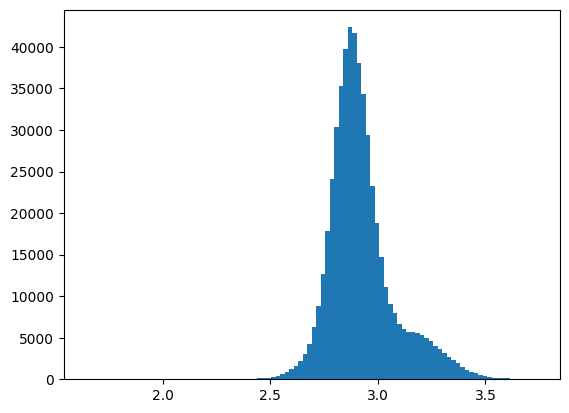

In [61]:
_ =  plt.hist([np.log10(len(i)) for i in all_sentences if len(i) > 0], bins=100)

In [17]:
sentence_tokens = sp_processor.encode_as_ids(all_sentences[0:10000])

In [30]:
from collections import Counter

c = Counter(s for story in all_sentences[0:2000] for s in story.lower().split())

In [31]:
c.most_common(100)  #

[('the', 19446),
 ('and', 15380),
 ('to', 11073),
 ('a', 10305),
 ('was', 9370),
 ('he', 7614),
 ('she', 7045),
 ('they', 4960),
 ('it', 4864),
 ('her', 3894),
 ('in', 2947),
 ('his', 2923),
 ('so', 2905),
 ('with', 2632),
 ('of', 2603),
 ('had', 2327),
 ('that', 2185),
 ('but', 2071),
 ('little', 1853),
 ('one', 1806),
 ('very', 1771),
 ('for', 1765),
 ('there', 1690),
 ('you', 1653),
 ('on', 1598),
 ('said,', 1457),
 ('day,', 1445),
 ('once', 1408),
 ('saw', 1358),
 ('were', 1343),
 ('big', 1269),
 ('mom', 1246),
 ('wanted', 1214),
 ('upon', 1183),
 ('girl', 1162),
 ('all', 1144),
 ('is', 1137),
 ('not', 1103),
 ('lily', 1095),
 ('said', 1063),
 ('at', 987),
 ('happy', 984),
 ('when', 979),
 ('play', 961),
 ('went', 939),
 ('be', 929),
 ('i', 920),
 ('their', 905),
 ('time,', 888),
 ('up', 881),
 ('have', 876),
 ('are', 837),
 ('from', 823),
 ('looked', 809),
 ('go', 798),
 ('would', 773),
 ('could', 753),
 ('day', 751),
 ('felt', 734),
 ('can', 733),
 ('him', 731),
 ('it.', 727),
 (

# Data generation utilities

In [67]:
# Lets create a dataset
T = 100  # Window size
V = VOCAB_SIZE
B = 16
SOS = "<SOS>"
EOS = "<EOS>"


# This is a bit slow because it generates S*(N - T) samples of length T each, where S is the number of sentences and N is the number of tokens in the sentence
# TODO: stupidly parallelize and load it into a numpy array and save it to a file, then memory map that file and load it into a torch tensor.
def data_generator(tokens):
    xy = []  # x: T word window, y is T+1th word

    for sentence_tokens in tokens:
        for i in range(0, len(sentence_tokens) - T):
            yield sentence_tokens[i : i + T], sentence_tokens[i + 1 : (i + T + 1)]


for x, y in data_generator(sp_processor.encode_as_ids([all_sentences[2301].lower()])):
    print(x, y)

[64, 7, 136, 53, 1502, 5, 15, 83, 9, 51, 3227, 20, 6, 112, 5, 15, 1504, 10, 182, 8, 274, 7, 541, 5, 15, 60, 86, 5, 30, 73, 15, 203, 118, 8, 15, 53, 691, 5, 54, 590, 60, 936, 7, 393, 5, 54, 763, 53, 591, 7, 1259, 5, 54, 33, 43, 44, 41, 5, 16, 339, 66, 23, 239, 49, 13, 102, 5, 16, 235, 53, 27, 691, 38, 23, 292, 9, 307, 3799, 7, 137, 590, 5, 67, 9, 6, 1290, 7, 158, 10, 2374, 5, 75, 115, 137, 590, 20, 6, 2163, 844, 5] [7, 136, 53, 1502, 5, 15, 83, 9, 51, 3227, 20, 6, 112, 5, 15, 1504, 10, 182, 8, 274, 7, 541, 5, 15, 60, 86, 5, 30, 73, 15, 203, 118, 8, 15, 53, 691, 5, 54, 590, 60, 936, 7, 393, 5, 54, 763, 53, 591, 7, 1259, 5, 54, 33, 43, 44, 41, 5, 16, 339, 66, 23, 239, 49, 13, 102, 5, 16, 235, 53, 27, 691, 38, 23, 292, 9, 307, 3799, 7, 137, 590, 5, 67, 9, 6, 1290, 7, 158, 10, 2374, 5, 75, 115, 137, 590, 20, 6, 2163, 844, 5, 93]
[7, 136, 53, 1502, 5, 15, 83, 9, 51, 3227, 20, 6, 112, 5, 15, 1504, 10, 182, 8, 274, 7, 541, 5, 15, 60, 86, 5, 30, 73, 15, 203, 118, 8, 15, 53, 691, 5, 54, 590, 60,

In [19]:
[f"<SOS>{sentence}<EOS>" for sentence in all_sentences[0:2]]

['<SOS>One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<EOS>',
 '<SOS>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many

In [63]:
all_data = list(
    data_generator(
        sp_processor.encode_as_ids(
            [f"<SOS>{sentence.lower()}<EOS>" for sentence in all_sentences[0:20000]]
        )
    )
)

In [65]:
len(all_data)

2284378

# The model

In [24]:
from itertools import chain

N_EMBED = 512
Dk = 64
Dv = 64
V = VOCAB_SIZE
P_DROPOUT = 0.5


class SelfAttentionHead(nn.Module):
    def __init__(self, device):
        self.device = device
        super(SelfAttentionHead, self).__init__()
        self.Wq = nn.Linear(N_EMBED, Dk)
        self.Wk = nn.Linear(N_EMBED, Dk)
        self.Wv = nn.Linear(N_EMBED, Dv)
        self.output_projection = nn.Linear(Dv, N_EMBED)
        self.residual_dropout = nn.Dropout(P_DROPOUT)

    def forward(self, x):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        a = torch.bmm(q, k.transpose(-2, -1)) / (Dk**0.5)
        self.effective_T = a.shape[1]
        mask = torch.tril(
            torch.ones(self.effective_T, self.effective_T, device=self.device)
        )
        mask = mask.masked_fill(
            mask[: self.effective_T, : self.effective_T] == 0, float("-inf")
        )
        a = a + mask
        a_softmax = torch.functional.F.softmax(a, dim=-1)
        weighted_attention = a_softmax @ v
        return self.residual_dropout(self.output_projection(weighted_attention))


class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.c_fc = nn.Linear(N_EMBED, N_EMBED * 2)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(N_EMBED * 2, N_EMBED)
        self.dropout = nn.Dropout(P_DROPOUT)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.ln_1 = nn.LayerNorm(N_EMBED)
        self.attn = SelfAttentionHead(device)
        self.ln_2 = nn.LayerNorm(N_EMBED)
        self.mlp = MLP()

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


# C = nn.Embedding(V, N_EMBED)
# The Query, Key and Value matrics for self attention
class TinyStoriesTransformer(nn.Module):
    def __init__(self, device):
        super(TinyStoriesTransformer, self).__init__()
        self.device = device
        self.C = nn.Embedding(V, N_EMBED)

        self.bn = nn.BatchNorm1d(N_EMBED, track_running_stats=True)
        self.block = Block(device)
        # TODO(Sid): Add positional encoding and possibly 3 separate layers for a forward projection *before* passing to Wq, Wk and Wv

        self.bn_after_ff = nn.BatchNorm1d(N_EMBED, track_running_stats=True)

        # Softmax layer
        self.final_projection = nn.Linear(N_EMBED, V)

    def forward(self, x):
        x_embed = self.C(x)  # T * N_EMBED
        x_embed_permuted = x_embed.permute(0, 2, 1)  # N_EMBED * T
        x_embed_normed = self.bn(x_embed_permuted)
        x_embed_normed = x_embed_normed.permute(0, 2, 1)  # T * N_EMBED
        # Sublayer 1 and 2, i.e. the ATTENTION and MLP along with residual connections.
        x_sublayer_12 = self.block(x_embed_normed)

        # Batch Norm
        ff_output_permuted = x_sublayer_12.permute(0, 2, 1)
        ff_output_normed = self.bn_after_ff(ff_output_permuted)
        ff_output_normed = ff_output_normed.permute(0, 2, 1)
        # # Final layer norm after we exit the
        # layer_norm_output_final = self.ln_ff(
        #     ff_output_normed
        # )  # T * N_HIDDEN, Residual connection
        return self.final_projection(ff_output_normed)  # B * T * V

## Initialize the model

In [71]:
tiny_story_model = TinyStoriesTransformer(device)
tiny_story_model.to(device)

TinyStoriesTransformer(
  (C): Embedding(10000, 512)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block): Block(
    (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (attn): SelfAttentionHead(
      (Wq): Linear(in_features=512, out_features=64, bias=True)
      (Wk): Linear(in_features=512, out_features=64, bias=True)
      (Wv): Linear(in_features=512, out_features=64, bias=True)
      (output_projection): Linear(in_features=64, out_features=512, bias=True)
      (residual_dropout): Dropout(p=0.5, inplace=False)
    )
    (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (c_fc): Linear(in_features=512, out_features=1024, bias=True)
      (gelu): GELU(approximate='none')
      (c_proj): Linear(in_features=1024, out_features=512, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (bn_after_ff): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [27]:
# Quick test for shapes.
with torch.no_grad():
    tiny_story_model.eval()
    op = tiny_story_model(torch.randint(0, 10000, (B, T)).to(device))
    print(op.shape)

torch.Size([128, 32, 10000])


In [72]:
LEARNING_RATE = 0.001
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    tiny_story_model.parameters(),
    lr=LEARNING_RATE,
)
# for parameter_values in parameters:
#     for parameter in parameter_values:
#         print(".", end="")
#         parameter.requires_grad = True

# Over fit a batch 

## Create a small batch

In [66]:
n_train = int(len(all_data) * 0.8)
train_data = all_data[0:n_train]
test_data = all_data[n_train:]
X_train = torch.tensor([i[0] for i in train_data])
Y_train = torch.tensor([i[1] for i in train_data])
X_test = torch.tensor([i[0] for i in test_data])
Y_test = torch.tensor([i[1] for i in test_data])

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    list(zip(X_train, Y_test)),
    batch_size=B,
    shuffle=False,
)
test_dataloader = DataLoader(
    list(zip(X_test, Y_test)),
    batch_size=B,
    shuffle=False,
)

In [30]:
def save_model(model, model_path, epoch, optimizer, loss):
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        },
        model_path,
    )


def load_model(model, model_path, optimizer):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

In [31]:
train_loss_values = []

In [53]:
for x, y in test_dataloader:
    print(x.shape, y.shape)
    break

NameError: name 'test_dataloader' is not defined

## Validation loop logic

In [68]:
def validation_loop(model, test_dataloader, loss_fn):
    model.eval()
    total_loss = 0
    num_batches = 0
    # test_loss_values = []
    with torch.no_grad():
        for x_batch, y_batch in enumerate(test_dataloader):

            # Forward pass
            z = model(x_batch.to(device))
            act = torch.softmax(z, dim=-1)  # B* T * V, where V is the
            # print(act.shape, y_sample.shape)

            act = act.view(-1, V)
            y_sample_view = y_batch.view(-1)

            loss = loss_fn(act, y_sample_view)

            # test_loss_values.append(loss.item())
            # print(loss.item())
            if torch.isnan(loss).any():
                print("NaN detected in test loss")
            num_batches += 1
            total_loss += loss.item()
    return total_loss / num_batches

In [55]:
X_train.shape

torch.Size([2913955, 32])

In [69]:
# Set a seed for numpy
np.random.seed(99999999)
# random_idx = np.random.randint(0, X_train.shape[0], 2000)
random_idx = np.arange(0, 200)
print(random_idx.shape)
X_batch, Y_batch = X_train[random_idx, :].to(device), Y_train[random_idx, :].to(device)
print(X_batch.shape, Y_batch.shape)

(200,)
torch.Size([200, 100]) torch.Size([200, 100])


In [36]:
X_batch.shape

torch.Size([4000, 32])

## Model training loop

In [81]:
n_epochs = 800
epochs_iter = iter(range(1, n_epochs))
tiny_story_model.train()
with tqdm(total=n_epochs, desc="Epochs", leave=False) as progress_bar:
    for epoch in epochs_iter:
        n_batches = 0
        # for X_batch, Y_batch in tqdm(train_dataloader, desc="Batches", leave=False):
        optimizer.zero_grad()
        z = tiny_story_model(X_batch)
        act = torch.softmax(z, dim=-1)  # B* T * V, where V is the
        # print(act.shape, y_sample.shape)

        act = act.view(-1, V)
        y_sample_view = Y_batch.view(-1)

        loss = ce_loss(act, y_sample_view)

        train_loss_values.append(loss.item())
        if epoch % 10 == 0:
            # print(".", end="")
            progress_bar.set_description(
                f"Epoch [{epoch}/{n_epochs}], Batch {n_batches}], Loss: {np.round(loss.item(), decimals=4)}, Last 5 losses: {', '.join([str(np.round(i, decimals=4)) for i in train_loss_values[-5:]])}"
            )

        # validation_loop(tiny_story_model, test_dataloader, ce_loss)
        # print(loss.item())
        loss.backward()
        optimizer.step()
        del z
        del act
        n_batches += 1
        if epoch % 799 == 0:
            save_model(
                tiny_story_model,
                f"model_overfitted_epoch_{(epoch)}_batch_{(epoch)}.pth",
                epoch,
                optimizer,
                loss,
            )
       

    # Cross entropy between the output of the FF layer_norm_output_final and the target y
    # print(act.shape)

Epochs:   0%|          | 0/800 [00:00<?, ?it/s]

In [38]:
z.shape, act.shape, y_sample_view.shape

(torch.Size([4000, 32, 10000]),
 torch.Size([128000, 10000]),
 torch.Size([128000]))

In [47]:
del tiny_story_model

NameError: name 'tiny_story_model' is not defined

In [45]:
del z
del act

NameError: name 'z' is not defined

In [46]:
import gc

gc.collect()
torch.cuda.empty_cache()


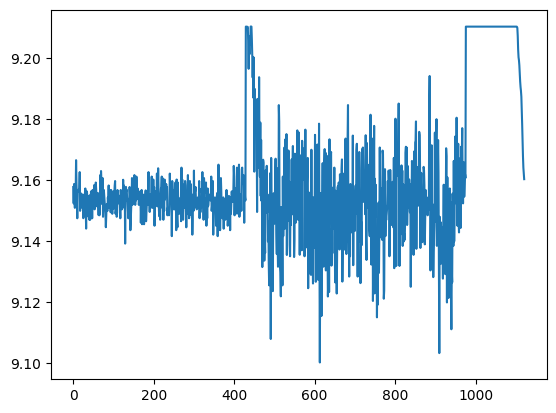

In [472]:
ax = plt.plot(train_loss_values[600:])

# Inference 

In [450]:
# grab a random token and make the network generate things
# def generate_text(model, sp_processor, test_sentence):
test_sentence = "The little girl"
tiny_story_model.eval()
# token = torch.randint(0, V, (1, 1)).to(device)
tokens = sp_processor.encode_as_ids(f"<SOS>{test_sentence}")
# print(tokens)
generated_text = []

tokens = torch.tensor([tokens]).to(device)
prev_tokens = tokens
# print(tokens.shape)
distributions_acts = []
max_probs_lst = []
for i in range(50):
    with torch.no_grad():
        z = tiny_story_model(prev_tokens)
        probs = torch.softmax(z, dim=-1)
        distributions_acts.append(act)
        probs = probs.view(-1, V)  # len(generated_tokens) +i * V
        # print(probs.shape)
        max_probs, max_idxs = torch.max(probs, dim=-1)
        max_probs_lst.append(max_probs[-1])
        token = max_idxs[-1]
        # print(token)
        # print(".")
        generated_text.append(int(token))
        prev_tokens = torch.cat((prev_tokens, torch.tensor([[token]])), dim=1)
decoded_text = sp_processor.decode_ids(generated_text)

print(test_sentence + " [" + decoded_text + " ]")

The little girl [.................................................. ]


In [395]:
sp_processor.decode_ids(generated_text)

'Once upon a little girl named Beep loved to go fast and said, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom,'

In [400]:
for t, p in zip(generated_text, max_probs_lst):
    print(sp_processor.decode(t), float(p), end=", ")

Once 0.9999822378158569, upon 0.9999823570251465, a 0.9999864101409912, little 0.9999864101409912, girl 0.9999818801879883, named 0.9999959468841553, Beep 0.9999864101409912, loved 0.9999868869781494, to 0.9794060587882996, go 0.9999847412109375, fast 0.9999902248382568, and 0.999988317489624, said 0.9999850988388062, , 0.9999988079071045, " 0.9879357814788818, Mom 0.9999853372573853, , 0.9999943971633911, " 0.990085244178772, Mom 0.9520663619041443, , 0.9999943971633911, " 0.9918128252029419, Mom 0.8985897898674011, , 0.9999943971633911, " 0.993184506893158, Mom 0.8695441484451294, , 0.9999943971633911, " 0.9942948222160339, Mom 0.851822018623352, , 0.9999943971633911, " 0.9951932430267334, Mom 0.8400238156318665, , 0.9999943971633911, " 0.9959267973899841, Mom 0.8316372632980347, , 0.9999943971633911, " 0.9965178966522217, Mom 0.82539302110672, , 0.9999943971633911, " 0.9970095157623291, Mom 0.820560097694397, , 0.9999943971633911, " 0.9974110722541809, Mom 0.81671142578125, , 0.9999

1485 2916
[8.04167969e-32 8.04167969e-32 8.04167969e-32 7.10832974e-05
 9.99884129e-01]


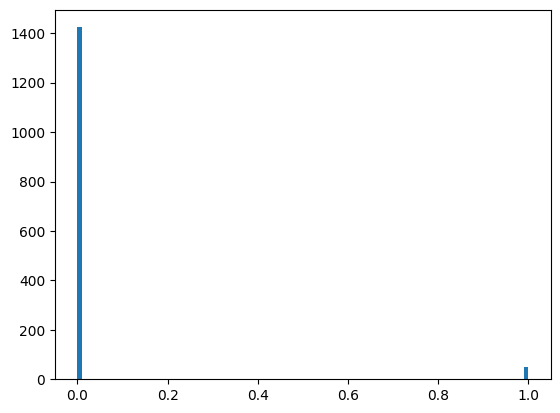

In [451]:
ax = plt.subplot()
vals = tiny_story_model.a_softmax.view(-1).detach().numpy()
print(np.count_nonzero(vals), len(vals))
non_zeros = vals[np.where(vals != 0)]
print(np.quantile(non_zeros, [0.01, 0.05, 0.5, 0.95, 0.99]))
_ = ax.hist(non_zeros, bins=100)

In [132]:
# Example of target with class indices
random_loss = nn.CrossEntropyLoss()
input = torch.tensor(
    [
        [
            [0.9, 5.8, 0.2, -0.65, 0.3],
            [0.9, -1.8, 0.2, 0.65, 7.3],
            [10.9, -1.8, 0.2, -0.65, 0.3],
        ],
        [
            [0.9, 5.8, 0.2, -0.65, 0.3],
            [0.9, -1.8, 0.2, 0.65, 7.3],
            [10.9, -1.8, 0.2, -0.65, 0.3],
        ],
    ],
    requires_grad=True,
)
target = torch.tensor([[1, 4, 0], [2, 1, 1]], dtype=torch.long)
print(input.shape, target.shape)
print(input, target)
input_view = input.view(-1, 5)
target_view = target.view(-1)
print(input_view.shape, target_view.shape)
print(input_view, target_view)
print(".")
output = random_loss(input_view, target_view)
print(output)
# output.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

torch.Size([2, 3, 5]) torch.Size([2, 3])
tensor([[[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
         [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
         [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]],

        [[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
         [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
         [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]]], requires_grad=True) tensor([[1, 4, 0],
        [2, 1, 1]])
torch.Size([6, 5]) torch.Size([6])
tensor([[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
        [10.9000, -1.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
        [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]],
       grad_fn=<ViewBackward0>) tensor([1, 4, 0, 2, 1, 1])
.
tensor(4.5735, grad_fn=<NllLossBackward0>)
